In [126]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal.windows import hann
from scipy.linalg import toeplitz, solve_toeplitz
import os
import librosa
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow.keras.layers as tfl
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from numpy.linalg import cond

In [142]:
def lpc(x, order, regularization=1e-12):
    R = np.correlate(x, x, mode='full')[len(x)-1:]
    R = R[:order+1]
    R[0] += regularization  # Apply regularization
    coeff = solve_toeplitz((R[:order], R[:order]), -R[1:])
    
    if coeff[0] == 0:  # Ensure the first coefficient is not zero
        coeff[0] = 1e-10  # Add a small value to avoid issues
    
    return coeff

In [151]:
def gfmiaif(s_gvl, iterations=1, nv=12, ng=3, enc_size=16, d=0.99, win=None):
    if win is None:
        win = hann(len(s_gvl))
    
    Lpf = nv + 1
    x_gvl = np.concatenate((np.linspace(-s_gvl[0], s_gvl[0], Lpf), s_gvl))
    idx_pf = slice(Lpf, len(x_gvl))
    
    al = [1, -d]
    s_gv = lfilter([1], al, s_gvl)
    x_gv = lfilter([1], al, x_gvl)
    
    ag1 = lpc(s_gv * win, 1)
    
    for _ in range(ng - 1):
        x_v1x = lfilter(ag1, [1], x_gv)
        s_v1x = x_v1x[idx_pf]
        ag1x = lpc(s_v1x * win, 1)
        ag1 = np.convolve(ag1, ag1x)
    
    x_v1 = lfilter(ag1, [1], x_gv)
    s_v1 = x_v1[idx_pf]
    av1 = lpc(s_v1 * win, nv)
    
    for _ in range(iterations):
        x_g1 = lfilter(av1, [1], x_gv)
        s_g1 = x_g1[idx_pf]
        ag = lpc(s_g1 * win, ng)
    
        x_v = lfilter(ag, [1], x_gv)
        s_v = x_v[idx_pf]
        av1 = lpc(s_v * win, nv)
        
    glottal_pulse = lfilter(av1, [1], s_gvl)
    ag=lpc(glottal_pulse * win, enc_size)
    
    return av1, ag, al

In [152]:
def generate_encoding(data_folder,num_speakers=5,num_frames=100,frame_length_msec=30,sr=44100,verbose=True,iteration=1):
    x_glot=[]
    x_vt=[]
    y_glot=[]
    y_vt=[]
    
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        total_time_data=num_frames*frame_length_msec
        curr_time=0
        
        y=[]
        wav_files=os.listdir(os.path.join(data_folder, speaker))
        idx=0
        while curr_time<total_time_data:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])

                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                y.append(y_curr)
                
                curr_time+=60000
                idx+=1
                
        del wav_files

        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(list(y[0]), frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_frames]
#         print(frames)
        
        del y

        for frame in frames:
            vt,glot,_=gfmiaif(frame,iteration)
            x_vt.append(vt)
            x_glot.append(glot)
            y_glot.append(speaker)
            y_vt.append(speaker)

            del vt,glot

        del frames
                        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")

        if total_speaker == num_speakers:
            break
    
    return x_vt,x_glot,y_vt,y_glot

In [153]:
num_speakers=5
frame_length_msec=3
num_frames=10000
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [154]:
x_vt,x_glot,y_vt,y_glot=generate_encoding(data_folder,num_speakers,num_frames,frame_length_msec)

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


1 speakers completed.

2 speakers completed.

3 speakers completed.

4 speakers completed.

5 speakers completed.



In [155]:
dict={}
i=0

unique=[]
for val in y_vt:
    if val not in unique:
        unique.append(val)

for val in unique:
    dict[val]=i
    i+=1

dict

{'Speaker0043': 0,
 'Speaker_0014': 1,
 'Speaker0029': 2,
 'Speaker0047': 3,
 'Speaker_0009': 4}

In [156]:
from sklearn.model_selection import train_test_split

X_train_vt, X_test_vt, y_train_vt, y_test_vt = train_test_split(x_vt,y_vt , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

X_train_glot, X_test_glot, y_train_glot, y_test_glot = train_test_split(x_glot,y_glot , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

In [157]:
i=0
for _ in y_train_vt:
    y_train_vt[i]=dict[y_train_vt[i]]
    i=i+1

i=0
for _ in y_test_vt:
    y_test_vt[i]=dict[y_test_vt[i]]
    i=i+1
    
i=0
for _ in y_train_glot:
    y_train_glot[i]=dict[y_train_glot[i]]
    i=i+1

i=0
for _ in y_test_glot:
    y_test_glot[i]=dict[y_test_glot[i]]
    i=i+1

In [158]:
def dnn_model(input_shape,output_shape):
    input_data = tf.keras.Input(shape=input_shape)
    
    D1 = tfl.Dense(512, activation='relu')(input_data)
#     DP1 = tfl.Dropout(0.5)(D1)
    
    D2 = tfl.Dense(256, activation='relu')(D1)
#     DP2 = tfl.Dropout(0.5)(D2)
    
    D3 = tfl.Dense(128, activation='relu')(D2)
#     DP3 = tfl.Dropout(0.5)(D3)
    
    outputs = tfl.Dense(output_shape, activation='softmax')(D3)
    
    model = tf.keras.Model(inputs=input_data, outputs=outputs)
    return model

In [159]:
model_vt = dnn_model((len(X_train_vt[0]),),num_speakers)
model_vt.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [160]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)
history = model_vt.fit(np.array(X_train_vt),np.array(y_train_vt), batch_size=32, epochs=100, validation_data=(np.array(X_test_vt),np.array(y_test_vt)),callbacks=(reduce_lr))

Epoch 1/100
  82/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3368 - loss: 1.6246

W0000 00:00:1724831511.628210     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4852 - loss: 1.1726

W0000 00:00:1724831514.135592     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4855 - loss: 1.1718 - val_accuracy: 0.6455 - val_loss: 0.7582 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6314 - loss: 0.7825 - val_accuracy: 0.6231 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6446 - loss: 0.7498 - val_accuracy: 0.6532 - val_loss: 0.7346 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6525 - loss: 0.7310 - val_accuracy: 0.6368 - val_loss: 0.7452 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6511 - loss: 0.7271 - val_accuracy: 0.6593 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6673 - loss: 0.7014 - val_accuracy: 0.6418 - val_loss: 0.7362 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6636 - loss: 

In [161]:
model_glot = dnn_model((len((X_train_glot[0]),),),num_speakers)
model_glot.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [162]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)
history = model_glot.fit(np.array(X_train_glot),np.array(y_train_glot), batch_size=32, epochs=100, validation_data=(np.array(X_test_glot),np.array(y_test_glot)),callbacks=(reduce_lr))

Epoch 1/100
  91/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4026 - loss: 1.3440

W0000 00:00:1724831769.309525     324 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1237/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6167 - loss: 0.9027

W0000 00:00:1724831771.741389     322 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6175 - loss: 0.9010 - val_accuracy: 0.7401 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7584 - loss: 0.5786 - val_accuracy: 0.7657 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7821 - loss: 0.5199 - val_accuracy: 0.7911 - val_loss: 0.4864 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7965 - loss: 0.4840 - val_accuracy: 0.8061 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8077 - loss: 0.4545 - val_accuracy: 0.8176 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8171 - loss: 0.4386 - val_accuracy: 0.8196 - val_loss: 0.4283 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8216 - loss: 

In [163]:
def create_train_triplets(X_train, y_train, num_triplets):
    triplets = []
    labels = np.unique(y_train)
    
    for _ in range(num_triplets):
        anchor_label = np.random.choice(labels)
        negative_label = np.random.choice(labels[labels != anchor_label])
        
        anchor_indices = np.where(y_train == anchor_label)[0]
        positive_indices = np.where(y_train == anchor_label)[0]
        negative_indices = np.where(y_train == negative_label)[0]
        
        anchor = X_train[np.random.choice(anchor_indices)]
        positive = X_train[np.random.choice(positive_indices)]
        negative = X_train[np.random.choice(negative_indices)]
        
        triplets.append((anchor, positive, negative))
    
    return np.array(triplets)

In [164]:
def create_test_triplets(X_test, y_test, num_triplets):
    triplets = []
    range_test = len(y_test)
    idx = np.arange(range_test)
    
    for _ in range(num_triplets):
        label_1 = np.random.choice(idx)
        label_2 = np.random.choice(idx)
        
        anchor = X_test[label_1]
        inp = X_test[label_2]
        out = 1 if y_test[label_1] == y_test[label_2] else 0
        
        triplets.append((anchor, inp, out))
        
    return np.array(triplets, dtype=object) 

In [170]:
def dnn_model_triplet_loss(input_shape):
    input_data = tf.keras.Input(shape=input_shape)
    
    D1 = tfl.Dense(512, activation='relu')(input_data)
    DP1 = tfl.Dropout(0.5)(D1)
    
    D2 = tfl.Dense(256, activation='relu')(DP1)
    DP2 = tfl.Dropout(0.5)(D2)
    
    outputs = tfl.Dense(128, activation='relu')(DP2)
        
    model = tf.keras.Model(inputs=input_data, outputs=outputs)
    return model

input_shape = (16,)
base_model = dnn_model_triplet_loss(input_shape)

In [171]:
def triplet_loss(y_true, y_pred, margin=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

In [172]:
anchor_input = tfl.Input(shape=input_shape, name='anchor_input')
positive_input = tfl.Input(shape=input_shape, name='positive_input')
negative_input = tfl.Input(shape=input_shape, name='negative_input')

encoded_anchor = base_model(anchor_input)
encoded_positive = base_model(positive_input)
encoded_negative = base_model(negative_input)

triplet_model_vt = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input],
                      outputs=[encoded_anchor, encoded_positive, encoded_negative])

triplet_model_vt.compile(optimizer='adam', loss=triplet_loss)

triplet_model_glot = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input],
                      outputs=[encoded_anchor, encoded_positive, encoded_negative])

triplet_model_glot.compile(optimizer='adam', loss=triplet_loss)

In [173]:
train_num=5000
test_num=100

In [174]:
triplets_train=create_train_triplets(X_train_glot,y_train_glot,train_num)

anchor_images = triplets_train[:, 0]
positive_images = triplets_train[:, 1]
negative_images = triplets_train[:, 2]

triplet_model_glot.fit([anchor_images, positive_images, negative_images], 
                  np.zeros((train_num, )),
                  batch_size=32, 
                  epochs=100)

Epoch 1/100
100/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7621    

W0000 00:00:1724832222.002541     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.7250
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5879 
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3189 
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3065 
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3347
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2008
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2065
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2418
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4267
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2800
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2419
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2491 
Epoch 13/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2757
Epoch 14/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2919
Epoch 15/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [187]:
triplets_test=create_test_triplets(X_test_glot,y_test_glot,test_num)

true_pos = 0
false_pos = 0

anchor_input_test = np.stack(triplets_test[:, 0])
positive_input_test = np.stack(triplets_test[:, 1])
labels_test = triplets_test[:, 2]

encoded_anchor = base_model.predict(anchor_input_test)
encoded_positive = base_model.predict(positive_input_test)

distances = np.linalg.norm(encoded_anchor - encoded_positive, axis=1)
threshold = 0.0005

for i in range(test_num):
    print(str(distances[i])+" : "+str(labels_test[i]))
    if distances[i] < threshold and labels_test[i] == 1:
        true_pos += 1
    if distances[i] >= threshold and labels_test[i] == 0:
        false_pos += 1

total_pos=np.sum(labels_test)

accuracy = (true_pos+false_pos) / test_num
true_pos = (true_pos) / total_pos
false_pos = (false_pos) / (test_num-total_pos)
print("True Positives: {:.2f}".format(true_pos))
print("False Positives: {:.2f}".format(false_pos))
print("Accuracy: {:.2f}".format(accuracy))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 1
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 1
0.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
True Positives: 1.00
False Positives: 0.00
Accuracy: 0.20


In [184]:
def plot_gfmiaif(s_gvl, iterations=1, nv=12, ng=3, enc_size=16, d=0.99, win=None):
    if win is None:
        win = hann(len(s_gvl))
    
    Lpf = nv + 1
    x_gvl = np.concatenate((np.linspace(-s_gvl[0], s_gvl[0], Lpf), s_gvl))
    idx_pf = slice(Lpf, len(x_gvl))
    
    al = [1, -d]
    s_gv = lfilter([1], al, s_gvl)
    x_gv = lfilter([1], al, x_gvl)
    
    ag1 = lpc(s_gv * win, 1)
    
    for _ in range(ng - 1):
        x_v1x = lfilter(ag1, [1], x_gv)
        s_v1x = x_v1x[idx_pf]
        ag1x = lpc(s_v1x * win, 1)
        ag1 = np.convolve(ag1, ag1x)
    
    x_v1 = lfilter(ag1, [1], x_gv)
    s_v1 = x_v1[idx_pf]
    av1 = lpc(s_v1 * win, nv)
    
    for _ in range(iterations):
        x_g1 = lfilter(av1, [1], x_gv)
        s_g1 = x_g1[idx_pf]
        ag = lpc(s_g1 * win, ng)
    
        x_v = lfilter(ag, [1], x_gv)
        s_v = x_v[idx_pf]
        av1 = lpc(s_v * win, nv)
        
    glottal_pulse = lfilter(av1, [1], s_gvl)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    t = []
    time = 0
    while len(t) < len(s_gvl):
        t.append(time)
        time += (1/sr)
    ax1.plot(t,s_gvl)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Amplitude')

    t = []
    time = 0
    while len(t) < len(glottal_pulse):
        t.append(time)
        time += (1/sr)
    ax2.plot(t,s_g1)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


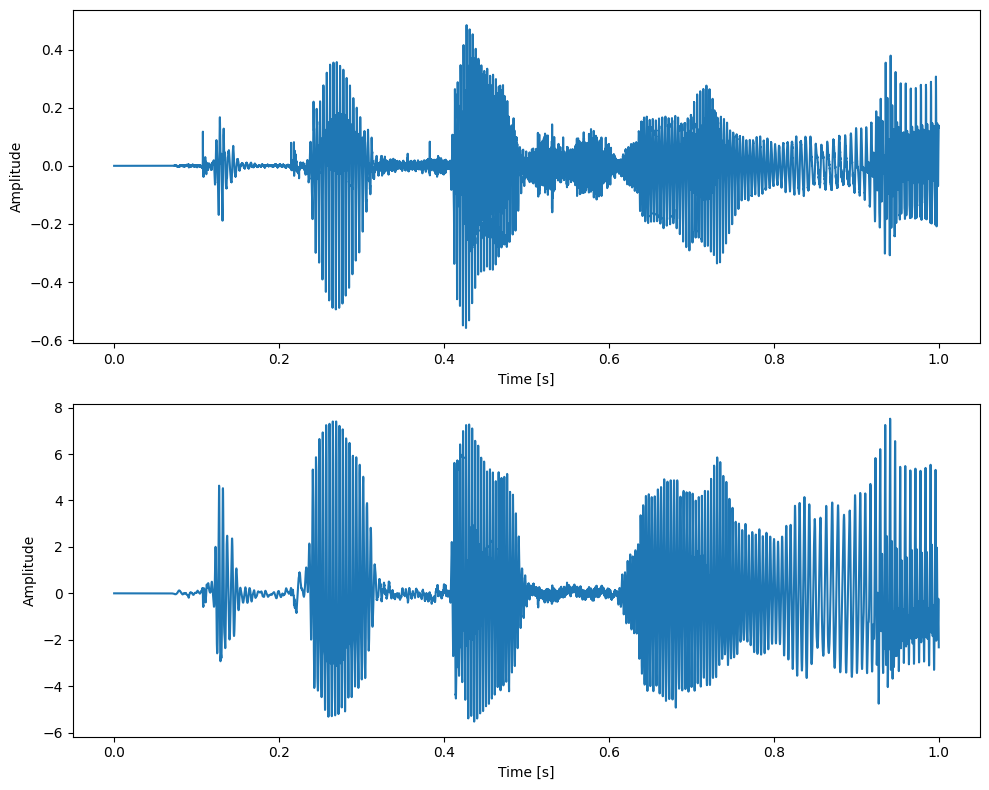

In [185]:
speakers=os.listdir(data_folder)
files=os.listdir(os.path.join(data_folder,speakers[0]))
s_gvl, sr = librosa.load(os.path.join(data_folder,speakers[0],files[0]), sr=44100)
s_gvl=s_gvl[:int(sr)]
plot_gfmiaif(s_gvl)

In [ ]:
# triplets_train=create_train_triplets(X_train_vt,y_train_vt,train_num)

# anchor_images = triplets_train[:, 0]
# positive_images = triplets_train[:, 1]
# negative_images = triplets_train[:, 2]

# triplet_model_vt.fit([anchor_images, positive_images, negative_images], 
#                   np.zeros((train_num, )),
#                   batch_size=32, 
#                   epochs=100)

In [ ]:
# triplets_test=create_test_triplets(X_test_vt,y_test_vt,test_num)

# true_pos = 0
# false_pos = 0

# anchor_input_test = np.stack(triplets_test[:, 0])
# positive_input_test = np.stack(triplets_test[:, 1])
# labels_test = triplets_test[:, 2]

# encoded_anchor = base_model.predict(anchor_input_test)
# encoded_positive = base_model.predict(positive_input_test)

# distances = np.linalg.norm(encoded_anchor - encoded_positive, axis=1)
# threshold = 0.057

# for i in range(test_num):
#     print(str(distances[i])+" : "+str(labels_test[i]))
#     if distances[i] < threshold and labels_test[i] == 1:
#         true_pos += 1
#     if distances[i] >= threshold and labels_test[i] == 0:
#         false_pos += 1

# total_pos=np.sum(labels_test)

# accuracy = (true_pos+false_pos) / test_num
# true_pos = (true_pos) / total_pos
# false_pos = (false_pos) / (test_num-total_pos)
# print("True Positives: {:.2f}".format(true_pos))
# print("False Positives: {:.2f}".format(false_pos))
# print("Accuracy: {:.2f}".format(accuracy))